# Fitting procedure for the IR-MS-EPI sequence

Introduction to define what the software is doing

## Input parameters 

You will have to specify the following parameters:
 * in_dir : input  directory
 * out_dir: output directory
 * sub_ID : subject ID, basename of input file
    
You will also have to specify the MR parameters of the sequence:
 * nTIs : numbers of acquired TIs (numbers of shift in the data)
 * MBfactor: acceleration factor in the slice direction (Multi-band or Simultaneous-Multi-Slice)
 * TR : repetition time (time between two inversion pulses)
 * sliceOffsets : array of the offsets introduced between shifts (it should have the number of elements specified  by nTIs)
 * minTI : the time between the inversion pulse and the first TI
 
Finally you can specify if you want to show the various images through the processing (show_data) or not.


In [1]:
import os

# Directory
in_dir = os.path.join(os.getcwd(),'data_example')
out_dir = os.path.join(os.getcwd(),'data_example')
sub_ID='whp7_0_11_22_33_44_55'

# Input MR parameters
nTIs=6;
MBfactor=3;
TR=3200
sliceOffsets=[0,11,22,33,44,55]
minTI=44.5

show_data=True

## Definition of the functions and various import necessary for the processing

This define the functions necessary for the fitting, and import modules necessary for loading images (nibabel) as well as modules necessary for the fitting (scipy).

In [2]:
import numpy as np
from numpy import exp
import time
import sys
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

def show_slices(slices,clims=[0.0,0.0]):
    fig, axes = plt.subplots(1,len(slices))
    for i, slice in enumerate(slices):
        if clims==[0.0,0.0]:
            axes[i].imshow(slice.T, cmap='gray', origin="lower")
        else:
            axes[i].imshow(slice.T, cmap='gray', origin="lower", clim=clims)
def size(A):
    sizei = 1
    for dim in np.shape(A): sizei = sizei*dim
    return sizei

## T1 fit functions
# TR is a global variable here...
def myT1fit2(t,T1,M0):
    fit =  M0 * (1 - 2*exp(-t/T1) + exp(- TR/T1));
    # e = (data(:) - fit(:))**2;
    return fit

def fitT12(sortTIi,modSlice,maskSlice2):
    datasize=int(modSlice.shape[0])
    t1=np.zeros((datasize,1))
    m0=np.zeros((datasize,1))
    r2=np.zeros((datasize,1))
    e2=np.zeros((datasize,1))
    #modSlice already flattened as input...
    for i in range(0,datasize):#range(int(datasize/2-1000),int(datasize/2+1000)):#
        if maskSlice2[i]:
            modSlicei=modSlice[i,:]
            params,pcov=curve_fit(myT1fit2,sortTIi,modSlicei,p0=[1000,modSlicei[-1]],
                                  bounds=[[0,0],[10000,1e7]],maxfev=500,ftol=0.01,xtol=0.01)
            t1[i]=params[0]
            m0[i]=params[1]
            r2[i]=sum((myT1fit2(sortTIi,params[0],params[1])-modSlicei)**2)
            e2[i]=np.sqrt(np.diag(pcov))[0]
        else:
            t1[i]=0
            m0[i]=0
            r2[i]=0
            e2[i]=0
    return t1,m0,r2,e2

def myT1fit3(t,T1,M0,alpha):
    fit =  M0 * (1 - alpha*exp(-t/T1) + exp(- TR/T1));
    #fit = M0 +alpha*exp(-t/T1)
    return fit

def fitT13(sortTIi,modSlice,maskSlice2):
    datasize=int(modSlice.shape[0])
    t1=np.zeros((datasize,1))
    m0=np.zeros((datasize,1))
    alpha=np.zeros((datasize,1))
    r2=np.zeros((datasize,1))
    e2=np.zeros((datasize,1))
    #modSlice already flattened as input...
    for i in range(0,datasize):#range(int(datasize/2-1000),int(datasize/2+1000)):#
        if maskSlice2[i]:
            modSlicei=modSlice[i,:]
            params,pcov=curve_fit(myT1fit3,sortTIi,modSlicei,p0=[1500,modSlicei[-1],1.9],
                                  bounds=[[0,0,1.5],[10000,1e10,2]],maxfev=1000,ftol=0.01,xtol=0.01)
            t1[i]=params[0]
            m0[i]=params[1]
            alpha[i]=params[2]
            r2[i]=sum((myT1fit3(sortTIi,params[0],params[1],params[2])-modSlicei)**2)
            e2[i]=np.sqrt(np.diag(pcov))[0]
        else:
            t1[i]=0
            m0[i]=0
            alpha[i]=0
            r2[i]=0
            e2[i]=0
    return t1,m0,alpha,r2,e2

## Load the input data and determine the size of the image

Note that the format of the data present here is the nifti (.hdr/.img) format. The first three dimensions represent x/y/z and the fourth dimension represent the different inversion time, or rather the different shift present. The different TIs as creating directly from the number of slices, number of shifts and the TR, assuming the slices are equally spaced. Note that the minTI is defined by the minimum time for the first slice and can vary dependent on the inversion time used (specific parameter in the patch). Note that the slices are acquired in an ascent fashion here (z from 0 to nS).

In [3]:
# Load input data
sub_dir=in_dir+'/'+sub_ID
imgm=nib.load(sub_dir+'_modulus.hdr')
imgm_img = imgm.get_fdata()
imgp=nib.load(sub_dir+'_phase.hdr')
imgp_img = imgp.get_fdata()

imgm_header=imgm.header
dimensions=imgm_header['dim']
nX=dimensions[1]
nY=dimensions[2]
nS=dimensions[3]
nTIs=dimensions[4]
nS_MB1=int(nS/MBfactor); #number of slices per band
Tseg=TR/nS_MB1;

#TIs=(0:1:(nS_MB1-1))*Tseg+ones(1,nS_MB1)*44.5; 
TIs = minTI + Tseg*np.arange(0,nS_MB1,1,dtype=float)

#TIs=repmat(TIs,[1 MBfactor]);
TIs=np.tile(TIs,(1,MBfactor))

# Default ascend order goes from 1 to nS
default=np.arange(1,nS_MB1+1,1)

ascend=np.zeros((len(sliceOffsets),nS))
ascendMB1=np.zeros((len(sliceOffsets),nS_MB1))


for sJump in range(0,len(sliceOffsets)):
    ascendMB1[0:nS_MB1-1][sJump]=np.roll(default,-sliceOffsets[sJump])

if MBfactor>1:
    for sJump in range(0,len(sliceOffsets)):
        ascend[sJump]=np.tile(ascendMB1[sJump], (1,MBfactor));
        for iBand in range(2,MBfactor+1,1):
            firstslice=nS_MB1*(iBand-1)
            subslices=np.arange(firstslice,nS_MB1*iBand)
            ascend[sJump][subslices]=ascend[sJump][subslices]+nS_MB1*(iBand-1); # this needs to be fixed-how to acces pat of the array
else: 
    ascend=ascendMB1;


[12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65.
 66.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
[ 12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.
  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.
  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.
  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.   1.
   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  78.  79.  80.  81.
  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.
  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109.
 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123.
 124. 125. 126. 127. 128. 129. 130. 131. 132.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  77. 144. 145. 146. 147. 148. 149. 150. 151.
 152. 153. 154. 155. 

## Sorting out the slice order vs the TIs

The different slices in the volumes are sorted in an increasing TI, so that each volume contain the $i^{th}$ inversion time dataset.

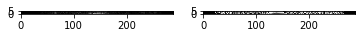

In [4]:
sortTI=np.zeros((len(sliceOffsets),nS))
sortTIindex=np.zeros((len(sliceOffsets),nS),dtype=int)
sortTI2=np.zeros((len(sliceOffsets),nS))

modData=np.zeros((nX,nY,nS,nTIs))
phData=np.zeros((nX,nY,nS,nTIs))

TI_slice=np.zeros((len(sliceOffsets),nS))
for iSlice in range(0,nS): 
    for sJump in range (0,len(sliceOffsets)):
        #put into TI_slice the actual TI based on TIs array
        a=[int(y-1) for y in ascend[sJump]] 
        if iSlice in a:
            TI_slice[sJump][iSlice]=TIs[0][a.index(iSlice)]

sortTI=np.sort(TI_slice,axis=0)
sortTIindex=np.argsort(TI_slice,axis=0)


for iSlice in range(0,nS): 
    #Need to sort data so that TIs etc are in increasing order
    index=sortTIindex[:,iSlice]
    modData[:,:,iSlice,:]=imgm_img[:,:,iSlice,index]; 
    phData[:,:,iSlice,:]=imgp_img[:,:,iSlice,index]; 

if show_data:
    show_slices([modData[:,100,10,:],phData[:,100,10,:]])
    

## Rearranging the data

The reshuffled data is saved as nifti files ($XXX_rearranged.nii.gz$) and a mask is created based on the signal intensity throught the slices. An arbitrary threshold is used here, but more complex threshold could be implemented.

In [ ]:
Rearranged_img = nib.nifti1.Nifti1Image(modData, None, header=imgm.header)
Rearranged_img.to_filename(sub_dir+'_modulus_rearranged.nii.gz')
Rearranged_phs = nib.nifti1.Nifti1Image(phData, None, header=imgp.header)
Rearranged_phs.to_filename(sub_dir+'_phase_rearranged.nii.gz')
#maskDatab=np.zeros((nX,nY,nS),dtype=bool)
maskDatai=np.zeros((nX,nY,nS),dtype=int)

maskData=(np.sum(modData,axis=3)>10)
maskDatai=maskData.astype(int)
    
print(imgm.header.get_data_shape())
mask = nib.nifti1.Nifti1Image(maskDatai, imgm.affine)
mask.to_filename(sub_dir+'_mask.nii.gz')    

imgm=nib.load(sub_dir+'_mask.nii.gz')
maskData = imgm.get_fdata()
maskDatai=maskData.astype(int)

# It is possible to load a mask generated by bet instead:
# command1: fslmaths T1_16_1_modulus -Tmean T1_16_1_avg
# command2: bet T1_16_1_avg.nii.gz T1_16_1_mask -m -Z -f 0.2

## Data fitting 

The routine contain the sign correction using the phase signal, assuming the last TI has a positive magnetization. The fit can be done for two parameters ($T_1$ and $M_0$) or three parameters ($T_1$, $M_0$ and $\alpha$, the inversion efficiency).
The running time is outputed for each slice, and the sum-of-square error is also saved (r2)

In [7]:
# T1 fit routine:
T1fit=np.zeros((nX,nY,nS))
M0fit=np.zeros((nX,nY,nS))
alphafit=np.zeros((nX,nY,nS))
r2fit=np.zeros((nX,nY,nS))
e2fit=np.zeros((nX,nY,nS))
modSlice=np.zeros((nX,nY,nS))

#print(type(nX))
sisl=int(nX)*int(nY)*int(nTIs)
nXY=int(nX)*int(nY)
phSlice=np.zeros((nX,nY,nTIs))#float64 by default
phDiff0=np.zeros((sisl,1))
phDiff=np.zeros((nX,nY,nTIs))
phDiff2=np.zeros((nXY,nTIs))
indices=np.zeros((nXY,nTIs),dtype=bool)
modSlice=np.zeros((nX,nY,nS))
modSlice2=np.zeros((int(nX)*int(nY),nS))

show_data=False

for iSlice in range(0,nS):#nS
    start_time = time.time()
#     if maskDatab[:,:,iSlice]:  
    print('Computing slice '+str(iSlice))
    modSlice= modData[:,:,iSlice,:]
    phSlice = phData[:,:,iSlice,:]
    maskSlice = maskDatai[:,:,iSlice]
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #Perform correction of modulus polarity based on phase 
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # get phase reference
    phRef = phSlice[:,:,-1]
    
    phDiff = np.repeat(phRef,nTIs,axis=1).reshape(nX,nY,nTIs) - phSlice;
    # add 2*pi to locations where PH < 0
    phDiff0=phDiff.ravel()
    aa=phDiff0<0
    phDiff0[aa]=phDiff0[aa]+2*np.pi
    
    phDiff2 = phDiff0.reshape(nXY,nTIs)
    
    if show_data:
        show_slices([phDiff[:,:,0],phDiff[:,:,1]])
        
    modSlice2 = np.reshape(modSlice,(nXY,nTIs))
    maskSlice2 = np.reshape(maskSlice,(nXY,1))
    
    for ipix in range(0,nXY):
        i_jump=nTIs-1
        while i_jump >= 0: #range(nTIs-1,0,-1):
            indices[ipix,i_jump] = np.equal(np.greater(phDiff2[ipix,i_jump],np.pi/2), \
                                            np.less(phDiff2[ipix,i_jump],3*np.pi/2))
            if indices[ipix,i_jump]:
                for i_jumpi in range(0,i_jump+1):
                    modSlice2[ipix,i_jumpi] = -modSlice2[ipix,i_jumpi]
                    indices[ipix,i_jumpi]=True
                break
            else:
                i_jump=i_jump-1
    
    if show_data:
        # Polarity corrected
        modSlice = np.reshape(modSlice2,(nX,nY,1,nTIs))
        show_slices([modSlice[:,:,0,0],modSlice[:,:,0,1]])
        show_slices([modSlice[:,:,0,2],modSlice[:,:,0,3]])
    
    #Perform fit and save result for this slice?!?
    t1,m0,r2,e2=fitT12(sortTI[:,iSlice],modSlice2,maskSlice2)
    #t1,m0,alpha,r2,e2=fitT13(sortTI[:,iSlice],modSlice2,maskSlice2)

     
    #save results in 3D array
    T1fit[:,:,iSlice]=np.reshape(t1,(nX,nY))
    M0fit[:,:,iSlice]=np.reshape(m0,(nX,nY))
    #alphafit[:,:,iSlice]=np.reshape(alpha,(nX,nY))
    r2fit[:,:,iSlice]=np.reshape(r2,(nX,nY))
    e2fit[:,:,iSlice]=np.reshape(e2,(nX,nY))
    print("--- %s seconds ---" % (time.time() - start_time))
  
# save out data
t1img=nib.nifti1.Nifti1Image(T1fit, imgm.affine)
t1img.to_filename(sub_dir+'_T1.nii.gz')  
m0img=nib.nifti1.Nifti1Image(M0fit, imgm.affine)
m0img.to_filename(sub_dir+'_M0.nii.gz')  
#alphaimg=nib.nifti1.Nifti1Image(alphafit, imgm.affine)
#alphaimg.to_filename(sub_dir+'_alpha.nii.gz')  
r2img=nib.nifti1.Nifti1Image(r2fit, imgm.affine)
r2img.to_filename(sub_dir+'_R2.nii.gz')  
e2img=nib.nifti1.Nifti1Image(e2fit, imgm.affine)
e2img.to_filename(sub_dir+'_E2.nii.gz')  


Computing slice 0
--- 181.55951142311096 seconds ---
Computing slice 1
--- 181.77531838417053 seconds ---
Computing slice 2
--- 179.23604941368103 seconds ---
Computing slice 3
--- 177.33565616607666 seconds ---
Computing slice 4
--- 164.30030059814453 seconds ---
Computing slice 5
--- 164.0224552154541 seconds ---
Computing slice 6
--- 163.52751421928406 seconds ---
Computing slice 7
--- 163.75231075286865 seconds ---
Computing slice 8
--- 164.53100895881653 seconds ---
Computing slice 9
--- 166.87812089920044 seconds ---
Computing slice 10
--- 168.55291104316711 seconds ---
Computing slice 11
--- 169.8439450263977 seconds ---
Computing slice 12
--- 167.47761607170105 seconds ---
Computing slice 13
--- 167.77135705947876 seconds ---
Computing slice 14
--- 167.67549848556519 seconds ---
Computing slice 15
--- 167.9168713092804 seconds ---
Computing slice 16
--- 167.89007186889648 seconds ---
Computing slice 17
--- 168.82360243797302 seconds ---
Computing slice 18
--- 167.79629349708557

--- 144.87673425674438 seconds ---
Computing slice 153
--- 143.96720170974731 seconds ---
Computing slice 154
--- 144.62914967536926 seconds ---
Computing slice 155
--- 142.64403009414673 seconds ---
Computing slice 156
--- 141.85796928405762 seconds ---
Computing slice 157
--- 140.13700246810913 seconds ---
Computing slice 158
--- 139.87946391105652 seconds ---
Computing slice 159
--- 139.838280916214 seconds ---
Computing slice 160
--- 139.19293904304504 seconds ---
Computing slice 161
--- 138.45065474510193 seconds ---
Computing slice 162
--- 137.38647484779358 seconds ---
Computing slice 163
--- 136.23228311538696 seconds ---
Computing slice 164
--- 136.01993942260742 seconds ---
Computing slice 165
--- 136.21200442314148 seconds ---
Computing slice 166
--- 134.75249600410461 seconds ---
Computing slice 167
--- 133.16884112358093 seconds ---
Computing slice 168
--- 132.49183678627014 seconds ---
Computing slice 169
--- 131.39988613128662 seconds ---
Computing slice 170
--- 131.1403

In [8]:
if show_data:
    t1s = np.reshape(t1,(nX,nY))
    m0s = np.reshape(m0,(nX,nY))
    r2s = np.reshape(r2,(nX,nY))
    #phDiff = np.reshape(phDiff2,(nX,nY,1,nTIs)) 
    show_slices([t1s,m0s])
    show_slices([r2s,t1s])

    T1fit[:,:,iSlice]=np.reshape(t1,(nX,nY))
    M0fit[:,:,iSlice]=np.reshape(m0,(nX,nY))
    r2fit[:,:,iSlice]=np.reshape(r2,(nX,nY))

